# Texas

## Contents
- [Imports](#Data-Dictionary)
- [Regression Modeling](#Regression-Modeling)  
- [Classification Modeling](#Classification-Modeling)  

# Imports

In [36]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, plot_confusion_matrix

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer, QuantileTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [37]:
# Import the data as a dataframe and save to a variable.
df = pd.read_csv('../data/cleaned_engineered_tx.csv')

In [38]:
# Display the first few rows of the dataframe.
df.head(2)

,county_state,total_cases,total_fatalities,death_rate,total_tests,race_pop,race_pop_hispanic_or_latino_of_any_race,race_pop_white_alone,race_pop_black_or_african_american_alone,race_pop_american_indian_and_alaska_native_alone,...,percent_race_pop_other,percent_race_pop_minority,percent_sex_age_pop_0_to_44,percent_sex_age_pop_45_to_74,percent_sex_age_pop_75_and_over,percent_sex_age_pop_0_to_64,percent_sex_age_pop_65_and_over,percent_sex_age_pop_0_to_35,percent_sex_age_pop_35_to_59,percent_sex_age_pop_60_to_84
0,"Anderson County, Texas",2941.0,39.0,0.013261,30052,57863,10142,34312,12127,158,...,0.016643,0.407013,0.597619,0.344659,0.057723,0.858303,0.141697,0.426438,0.369684,0.189033
1,"Andrews County, Texas",584.0,10.0,0.017123,2127,17818,9979,7215,321,0,...,0.013470,0.595072,0.678022,0.277079,0.044898,0.896565,0.103435,0.554944,0.293299,0.138455


# Regression Modeling

## Explainable Model: GridSearchCV with Power, SelectKBest, Ridge: 45%

Model performance improved with dropping some outliers.

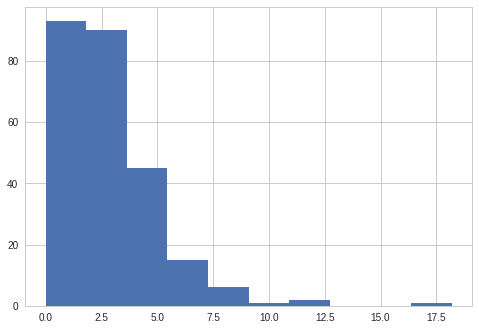

In [39]:
# Display histogram of deaths per 100 cases for Texas.
df['deaths_per_100_cases'].hist();

In [40]:
# Display outliers for deaths per 100 cases.
df[df['deaths_per_100_cases'] > 10]

,county_state,total_cases,total_fatalities,death_rate,total_tests,race_pop,race_pop_hispanic_or_latino_of_any_race,race_pop_white_alone,race_pop_black_or_african_american_alone,race_pop_american_indian_and_alaska_native_alone,...,percent_race_pop_other,percent_race_pop_minority,percent_sex_age_pop_0_to_44,percent_sex_age_pop_45_to_74,percent_sex_age_pop_75_and_over,percent_sex_age_pop_0_to_64,percent_sex_age_pop_65_and_over,percent_sex_age_pop_0_to_35,percent_sex_age_pop_35_to_59,percent_sex_age_pop_60_to_84
130,"Kenedy County, Texas",11.0,2.0,0.181818,86,595,522,72,0,0,...,0.000000,0.878992,0.544538,0.369748,0.085714,0.771429,0.228571,0.465546,0.290756,0.206723
223,"Throckmorton County, Texas",17.0,2.0,0.117647,118,1567,235,1292,16,0,...,0.015316,0.175495,0.467773,0.415444,0.116784,0.751117,0.248883,0.393108,0.275048,0.305680
230,"Upton County, Texas",27.0,3.0,0.111111,536,3634,1837,1525,237,5,...,0.002752,0.580352,0.604568,0.329664,0.065768,0.849752,0.150248,0.479086,0.316731,0.187672


In [41]:
# Drop the outliers
df = df[df['deaths_per_100_cases'] < 10]

In [62]:
# Assign our features to X and y.
X = df[[
    'inc_per_capita_inc_dol',
    'percent_health_ins_noninst_pop_cov_yes',
    'percent_race_pop_white_alone',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_two_or_more_races',
    'percent_race_pop_asian_alone',
    'percent_sex_age_pop_male',
    'percent_inc_hhlds_less_than_49_999',
    'percent_inc_hhlds_75_000_to_99_999',
    'percent_sex_age_pop_0_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'obes_percent',
    'pop_density',
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [63]:
# Display the shape of the training and test data.
X_train.shape, X_test.shape

((187, 16), (63, 16))

In [64]:
# Create a pipeline.
pipe = make_pipeline(PowerTransformer(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,14),
    'ridge__alpha': [1, 10, 20]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [65]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('powertransformer', PowerTransformer()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f2a4ea90b90>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [1, 10, 20],
                         'selectkbest__k': range(1, 14)},
             scoring='r2')

In [66]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 10, 'selectkbest__k': 12}

In [67]:
# Display the score for the test set.
print(f'Test R2 Score: {round(gs.score(X_test, y_test), 4)}.')

Test R2 Score: 0.45.


In [68]:
# Display the score for the training set.
print(f'Train R2 Score: {round(gs.score(X_train, y_train), 4)}.')

Train R2 Score: 0.4697.


In [69]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print(f'RMSE of Model:{round(mean_squared_error(y_test, y_preds, squared=False), 4)}.')

RMSE of Model:1.1307.


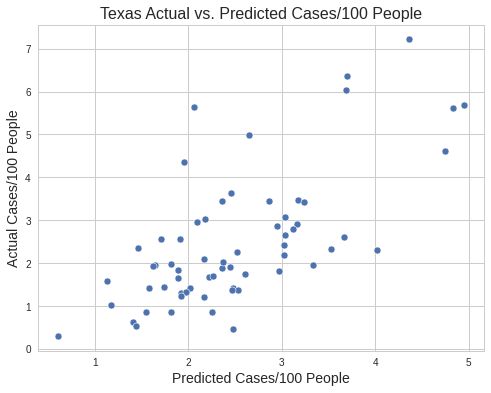

In [70]:
# Plot the predicted versus the actual 'cases_per_100_people'.
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('Texas Actual vs. Predicted Cases/100 People', fontsize=16)
plt.xlabel('Predicted Cases/100 People', fontsize=14)
plt.ylabel('Actual Cases/100 People', fontsize=14);

In [71]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()

In [72]:
# Overlay the boolean matrix with the features to get the features used.
features = X_train.columns[features==True]

In [73]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['ridge'].coef_

In [74]:
# Create a dataframe of the features and their coefficients.
coef_df = pd.DataFrame(list(zip(features, coefs)), columns=['Feature', 'Coefficients'])
coef_df = coef_df.set_index('Feature')
coef_df = coef_df.sort_values(by='Coefficients', ascending=False)

In [75]:
# Rename the index.
coef_df = coef_df.rename(index={
    'inc_per_capita_inc_dol': 'Income Per Capita ($)',
    'percent_inc_hhlds_less_than_49_999': 'Income < $50,000',
    'percent_inc_hhlds_50_000_to_99_999': 'Income: $50-100,000',
    'percent_inc_hhlds_75_000_to_99_999': 'Income: $75-100,000',
    'percent_inc_hhlds_less_than_99_999': 'Income: < $100,000',
    'percent_inc_hhlds_100_000_or_more': 'Income: > $100,000',
    'obes_percent': 'Obesity (%)',
    'pop_density': 'Population Density',
    'percent_health_ins_noninst_pop_cov_no': 'Health Insurance: None (%)',
    'percent_health_ins_noninst_pop_cov_yes': 'Health Insurance: Yes (%)',
    'percent_sex_age_pop_male': 'Sex: Male (%)',
    'percent_sex_age_pop_under_5': 'Age: Under 5 Yrs (%)',
    'percent_sex_age_pop_5_to_9': 'Age: 5-9 Yrs (%)',
    'percent_sex_age_pop_10_to_14': 'Age: 10-14 Yrs (%)',
    'percent_sex_age_pop_15_to_19': 'Age: 15-19 Yrs (%)',
    'percent_sex_age_pop_20_to_24': 'Age: 20-24 Yrs (%)',
    'percent_sex_age_pop_25_to_34': 'Age: 25-34 Yrs (%)',
    'percent_sex_age_pop_35_to_44': 'Age: 35-44 Yrs (%)',
    'percent_sex_age_pop_45_to_74': 'Age: 45-75 Yrs (%)',
    'percent_sex_age_pop_75_and_over': 'Age: 75+ Yrs (%)',
    'percent_sex_age_pop_0_to_44': 'Age: 0-44 Yrs (%)',
    'percent_race_pop_asian_alone': 'Race: Asian (%)',
    'percent_race_pop_american_indian_and_alaska_native_alone': 'Race: American Indian/Alaskan (%)',
    'percent_race_pop_native_hawaiian_and_other_pacific_islander_alone': 'Race: Pacific Islander (%)',
    'percent_race_pop_black_or_african_american_alone': 'Race: Black/African American (%)',
    'percent_race_pop_hispanic_or_latino_of_any_race': 'Race: Hispanic/Latino (%)',
    'percent_race_pop_two_or_more_races': 'Race: Two or More Races (%)',
    'percent_race_pop_some_other_race_alone': 'Race: Other (%)',
    'percent_race_pop_white_alone': 'Race: White (%)',
    'percent_race_pop_minority': 'Race: Minority (%)',
    'tests_per_100_people': 'Tests/100 People'
})

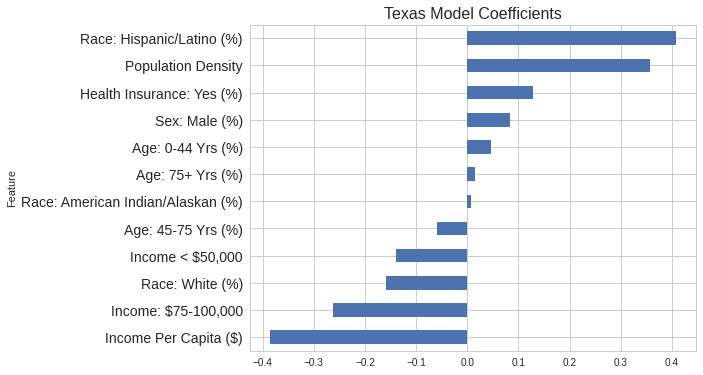

In [76]:
# Plot the datatframe of the features and their coefficients.
coef_df.sort_values(by='Coefficients').plot(kind = 'barh', figsize=(8,6), legend=None)
plt.title('Texas Model Coefficients', fontsize=16)
plt.yticks(fontsize=14);

### Create a smaller coefficient dataframe

In [77]:
coef_neg = coef_df.sort_values(by='Coefficients')[:5]

In [78]:
coef_pos = coef_df.sort_values(by='Coefficients', ascending=False)[:5]

In [79]:
coef_df = pd.concat([coef_neg, coef_pos]).sort_values(by='Coefficients', ascending=False)

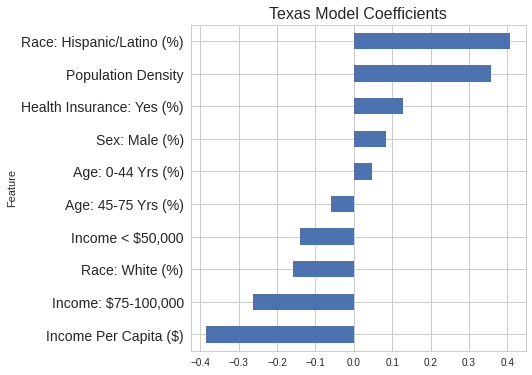

In [80]:
# Plot the datatframe of the features and their coefficients.
coef_df.sort_values(by='Coefficients').plot(kind = 'barh', figsize=(6,6), legend=None)
plt.title('Texas Model Coefficients', fontsize=16)
plt.yticks(fontsize=14);

## Blackbox Model: Power, Polynomial, Gridsearch, Ridge: 49%

In [81]:
# Assign our features to X and y.
X = df[[
    'sex_age_median_age_in_years',
    'percent_race_pop_minority',
    'percent_race_pop_white_alone',
    'inc_per_capita_inc_dol',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'percent_inc_hhlds_less_than_10_000',
    'percent_inc_hhlds_75_000_to_99_999',
    'percent_inc_hhlds_less_than_49_999',
    'percent_race_pop_minority',
    'percent_sex_age_pop_0_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'obes_percent',
    'pop_density',
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [82]:
# Display the shape of the training and test data.
X_train.shape, X_test.shape

((187, 15), (63, 15))

In [83]:
# Create a pipeline.
pipe = make_pipeline(PowerTransformer(), PolynomialFeatures(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,150),
    'ridge__alpha': [1, 10, 20, 30, 100, 150]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [84]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('powertransformer', PowerTransformer()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f2a4ea90b90>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [1, 10, 20, 30, 100, 150],
                         'selectkbest__k': range(1, 150)},
             scoring='r2')

In [85]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 100, 'selectkbest__k': 82}

In [86]:
# Display the score for the test set.
print(f'Test R2 Score: {round(gs.score(X_test, y_test), 4)}.')

Test R2 Score: 0.4878.


In [87]:
# Display the score for the training set.
print(f'Train R2 Score: {round(gs.score(X_train, y_train), 4)}.')

Train R2 Score: 0.5809.


In [88]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print(f'RMSE of Model:{round(mean_squared_error(y_test, y_preds, squared=False), 4)}.')

RMSE of Model:1.0912.


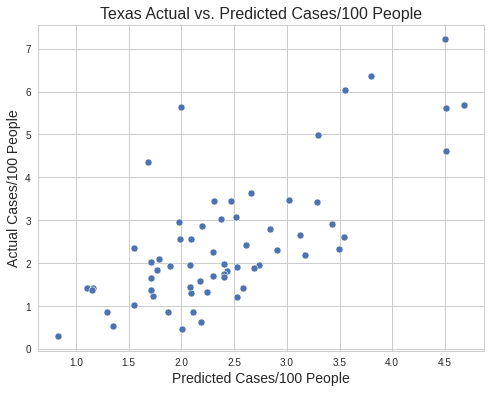

In [89]:
# Plot the predicted versus the actual 'cases_per_100_people'.
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('Texas Actual vs. Predicted Cases/100 People', fontsize=16)
plt.xlabel('Predicted Cases/100 People', fontsize=14)
plt.ylabel('Actual Cases/100 People', fontsize=14);

# Classification Modeling

## Simple Model: GridSearchCV with Classifier: 59% (baseline 40%)

In [134]:
# Assign our features to X and y.
X = df[[
    'sex_age_median_age_in_years',
    'percent_race_pop_minority',
    'percent_race_pop_white_alone',
    'inc_per_capita_inc_dol',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'percent_inc_hhlds_less_than_10_000',
    'percent_inc_hhlds_75_000_to_99_999',
    'percent_inc_hhlds_less_than_49_999',
    'percent_race_pop_minority',
    'percent_sex_age_pop_0_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'obes_percent',
    'pop_density',
]]

y = df['covid_severity']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [135]:
# Display the shape of the training and test data.
X_train.shape, X_test.shape

((187, 15), (63, 15))

In [136]:
# Display the baseline percentages.
y_test.value_counts(normalize=True)

1    0.396825
3    0.301587
2    0.301587
Name: covid_severity, dtype: float64

In [137]:
# Create a pipeline.
pipe = make_pipeline(QuantileTransformer(), SelectKBest(), LogisticRegression())

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,21),
    'logisticregression__C': [.1, .5, 1, 10]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1)

In [138]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1, 10],
                         'selectkbest__k': range(1, 21)})

In [139]:
# Display the best parameters.
gs.best_params_

{'logisticregression__C': 10, 'selectkbest__k': 1}

In [140]:
# Display the score for the test set.
print(f'Test Accuracy: {round(gs.score(X_test, y_test), 4)}.')

Test Accuracy: 0.5873.


In [141]:
# Display the score for the training set.
print(f'Train Accuracy: {round(gs.score(X_train, y_train), 4)}.')

Train Accuracy: 0.5989.


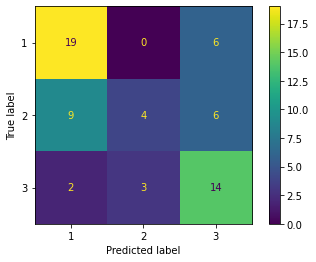

In [142]:
# Plot a confusion matrix.
y_preds = gs.predict(X_test)
plot_confusion_matrix(gs, X_test, y_test);

In [143]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()

In [144]:
# Overlay the boolean matrix with the features to get the features used.
features = X_train.columns[features==True]

In [145]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['logisticregression'].coef_

In [146]:
# Extract coefficients for each class and save to a variable.
coef1 = coefs[0]
coef2 = coefs[1]
coef3 = coefs[2]

In [147]:
pd.DataFrame(list(zip(features, coef1)), columns=['Feature', 'Covid Severity Low'])

,Feature,Covid Severity Low
0,percent_race_pop_white_alone,3.204114


In [148]:
pd.DataFrame(list(zip(features, coef2)), columns=['Feature', 'Covid Severity Medium'])

,Feature,Covid Severity Medium
0,percent_race_pop_white_alone,0.182773


In [149]:
pd.DataFrame(list(zip(features, coef3)), columns=['Feature', 'Covid Severity High'])

,Feature,Covid Severity High
0,percent_race_pop_white_alone,-3.386887


## Blackbox Model: Quantile, Polynomial, Gridsearch, Classifier: 57% (baseline 40)

In [150]:
# Assign our features to X and y.
X = df[[
    'obes_percent',
    'pop_density',
    'sex_age_median_age_in_years',
    'inc_med_hhld_inc_dol',
    'inc_mean_hhld_inc_dol',
    'inc_per_capita_inc_dol',
    'inc_med_earn_male_full_yr_workers_dol',
    'inc_med_earn_female_full_yr_workers_dol',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_white_alone',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_asian_alone',
    'percent_race_pop_native_hawaiian_and_other_pacific_islander_alone',
    'percent_race_pop_some_other_race_alone',
    'percent_race_pop_two_or_more_races',
    'percent_sex_age_pop_male',
    'percent_sex_age_pop_female',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_54',
    'percent_sex_age_pop_55_to_59',
    'percent_sex_age_pop_60_to_64',
    'percent_sex_age_pop_65_to_74',
    'percent_sex_age_pop_75_to_84',
    'percent_sex_age_pop_85_and_over',
    'percent_health_ins_noninst_pop_cov_yes',
    'percent_health_ins_noninst_pop_cov_no',
    'percent_inc_hhlds_less_than_10_000',
    'percent_inc_hhlds_10_000_to_14_999',
    'percent_inc_hhlds_15_000_to_24_999',
    'percent_inc_hhlds_25_000_to_34_999',
    'percent_inc_hhlds_35_000_to_49_999',
    'percent_inc_hhlds_50_000_to_74_999',
    'percent_inc_hhlds_75_000_to_99_999',
    'percent_inc_hhlds_100_000_to_149_999',
    'percent_inc_hhlds_150_000_to_199_999',
    'percent_inc_hhlds_200_000_or_more'
]]

y = df['covid_severity']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [151]:
# Display the shape of the training and test data.
X_train.shape, X_test.shape

((187, 43), (63, 43))

In [154]:
# Display the baseline percentages.
y_test.value_counts(normalize=True)

1    0.396825
3    0.301587
2    0.301587
Name: covid_severity, dtype: float64

In [152]:
# Create a pipeline.
pipe = make_pipeline(QuantileTransformer(), PolynomialFeatures(), SelectKBest(), LogisticRegression())

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'logisticregression__C': [.1, .5, 1, 10]
}

# Set up GridSearchCV with the pipe.
gs = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1)

In [153]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1, 10],
                         'selectkbest__k': range(1, 300)})

In [155]:
# Display the best parameters.
gs.best_params_

{'logisticregression__C': 10, 'selectkbest__k': 2}

In [156]:
# Display the score for the test set.
print(f'Test Accuracy: {round(gs.score(X_test, y_test), 4)}.')

Test Accuracy: 0.5714.


In [157]:
# Display the score for the training set.
print(f'Train Accuracy: {round(gs.score(X_train, y_train), 4)}.')

Train Accuracy: 0.5775.


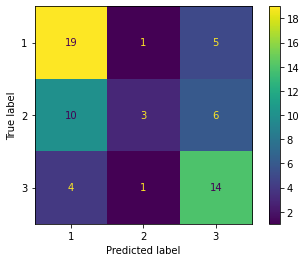

In [158]:
# Plot a confusion matrix.
y_preds = gs.predict(X_test)
plot_confusion_matrix(gs, X_test, y_test);